#This code follows tutorial of 
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

In [1]:
# Run in python console
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\inyoungjun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['&amp;', 'rt', 'coronavirus', 'koronavirus', 'corona','covid-19',
                   'covid_19','corona virus','covid', 'coronavirus','covid-19',
                   'covid19','sars-cov-2','covd','pandemic','covid__19',
                   'alabama','alaska','arizona','arkansas','california','colorado','connecticut','delaware','florida',
                   'georgia','hawaii','idaho','illinois','indiana','iowa','kansas','kentucky','louisiana','maine',
                   'maryland','massachusetts','michigan','minnesota','mississippi','missouri','montana','nebraska',
                   'nevada','new hampshire','new jersey', 'hampshire', 'jersey','new mexico','new york','york',
                   'north carolina','carolina','north dakota','dakota','ohio','oklahoma','oregon','pennsylvania',
                   'rhode island','south carolina','south dakota','tennessee','texas',
                   'utah','vermont','virginia','washington','west virginia','wisconsin','wyoming','us',
                   'san','francisco','miami','houston','philadelpia','nashville','seattle','brooklyn',
                   'usa','ca','la','austin','orlando','los','angeles','losangeles','atlanta','orleans','vegas',
                   'las','chicago','philadelphia'
                   
])


In [4]:
# Import Dataset
df = pd.read_csv("C:/Users/inyoungjun/Dropbox (Personal)/[research]year2/[research]TweetCOVID/coding/echen_dataset.csv")

df.head()

,id,text,clean_text,place,coordinates,user_location,created_at,username,user_id,us_state,retweet
0,1267670133574709249_id,@IamIanJacob @SaudiaSakari @localzvddy Better ...,@IamIanJacob @SaudiaSakari @localzvddy Better ...,"{'id': 'd6bbfe2356aebaab', 'url': 'https://api...",NaN,"Dallas, Texas",Tue Jun 02 04:11:26 +0000 2020,Tanner Wilson,2477561683,tx,0
1,1267670144370855936_id,Hope and prayers to you and all. https://t.co/...,Hope and prayers to you and all. https://t.co/...,"{'id': '1ed0698bc8262763', 'url': 'https://api...",NaN,Long Island NY,Tue Jun 02 04:11:29 +0000 2020,Bobby,787672052064985088,ny,0
2,1267670146753142784_id,https://t.co/Ogpjp4cZxE\n\n@realDonaldTrump......,https://t.co/Ogpjp4cZxE @realDonaldTrump... I...,"{'id': 'e4a0d228eb6be76b', 'url': 'https://api...",NaN,NaN,Tue Jun 02 04:11:29 +0000 2020,Tony Chen,1224343356995710977,pa,0
3,1267670165044572161_id,“his baiting also has the effect of distractio...,"""his baiting also has the effect of distractio...","{'id': '04cb31bae3b3af93', 'url': 'https://api...",NaN,"Miami, FL",Tue Jun 02 04:11:34 +0000 2020,Christina Vazquez,15840102,fl,0
4,1267670240676044800_id,@marrowtea If they didn’t act a fool during th...,@marrowtea If they didn't act a fool during th...,"{'id': '00430f8519d62c37', 'url': 'https://api...",NaN,Hilo & Baltimore,Tue Jun 02 04:11:52 +0000 2020,Andre,189956375,hi,0


In [5]:
# Convert to list
data = df.clean_text.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

#Remove http link
data = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', sent) for sent in data]

pprint(data[:10])

['Better politics yes, Pandemic no! I want to see my friends and family more '
 'often.',
 'Hope and prayers to you and all. ',
 ' Its enough 100 thousand lives gone by your inability in covid handling Now '
 'you want to make intern war like you do it in other country? This is your '
 'people Use peace and calm approach #USAonFire #USARIOTS #BlackLivesMatter',
 '"his baiting also has the effect of distraction." May 20, 2020 via "10 '
 'things Trump would like to distract you from focusing on":  ',
 'If they didnt act a fool during the initial stages of the pandemic and the '
 'BLM then its def safe to say vibe check =',
 'This is some next level clown shit. Fake ass people stay the fuck home. We '
 'dont want you. We dont need you. ',
 'The upside down smiley was more of an awkward dissaproval- I know Im new to '
 'Twitter again BUT DO PEOPLE ACTUALLY THINK COVID IS A LIE?',
 'LONG POST ALERT  #COVID19 #GeorgeFloyd #PoliceBrutality #StopRacismSaveLives '
 '#CowardinChief #BlackLivesMa

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['better', 'politics', 'yes', 'pandemic', 'no', 'want', 'to', 'see', 'my', 'friends', 'and', 'family', 'more', 'often']]


In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['better', 'politics', 'yes', 'pandemic', 'no', 'want', 'to', 'see', 'my', 'friends', 'and', 'family', 'more', 'often']


In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [55]:
%%time 
#14min 51s
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN'])

KeyboardInterrupt: 

In [56]:
print(data_lemmatized[:10])

[['politic', 'friend', 'family'], ['prayer'], ['life', 'inability', 'handling', 'want', 'war', 'country', 'people', 'peace', 'calm', 'approach', 'usaonfire', 'usariot'], ['distraction', 'thing', 'focusing'], ['fool', 'stage', 'vibe', 'check'], ['level', 'clown', 'shit', 'ass', 'people', 'home'], ['twitter', 'people'], ['policebrutality', 'cowardinchief'], ['social_distancing', 'wave'], ['man', 'tour']]


In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [63]:
id2word[2] #If want to see what a given id corresponds to, pass the id as a key to the dictionary

'politic'

In [12]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('family', 1), ('friend', 1), ('politic', 1)]]

In [13]:
%%time
#11/17 4:45 pm
#Previoulsy it took 22h 37min 4s #10 topic, 100 pass
#This time it took 10h 27 min 56s #10 topic, 100 pass
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=100,
                                           alpha='auto',
                                           per_word_topics=True)

Wall time: 10h 27min 56s


In [174]:
#Save LDA model
lda_model.save('C:/Users/inyoungjun/Dropbox (Personal)/[research]year2/[research]TweetCOVID/coding/result_1118/result_1118.lda')


In [14]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.101*"life" + 0.094*"state" + 0.032*"doctor" + 0.027*"folk" + '
  '0.026*"point" + 0.022*"vote" + 0.022*"heart" + 0.021*"delivery" + '
  '0.020*"election" + 0.019*"birthday"'),
 (1,
  '0.125*"day" + 0.052*"mask" + 0.025*"worker" + 0.025*"patient" + '
  '0.023*"video" + 0.023*"story" + 0.022*"question" + 0.022*"morning" + '
  '0.016*"face" + 0.015*"outbreak"'),
 (2,
  '0.067*"trump" + 0.050*"love" + 0.039*"man" + 0.028*"fact" + 0.026*"other" + '
  '0.023*"service" + 0.021*"risk" + 0.021*"call" + 0.020*"woman" + '
  '0.016*"tomorrow"'),
 (3,
  '0.069*"today" + 0.065*"social_distancing" + 0.055*"week" + 0.050*"year" + '
  '0.046*"world" + 0.025*"community" + 0.025*"care" + 0.024*"test" + '
  '0.021*"stayhome" + 0.014*"word"'),
 (4,
  '0.058*"order" + 0.057*"family" + 0.044*"health" + 0.034*"place" + '
  '0.033*"quarantinelife" + 0.030*"response" + 0.029*"hospital" + '
  '0.022*"night" + 0.022*"kid" + 0.020*"hand"'),
 (5,
  '0.192*"time" + 0.040*"government" + 0.025*"person" + 0.0

In [15]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

#A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.
#A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.446170 -0.042909       1        1  14.898012
3      0.010099  0.445973       2        1  12.568126
8      0.013311 -0.022198       3        1  11.336514
1      0.035656 -0.037932       4        1  11.093260
6      0.063709 -0.060687       5        1   9.936084
4      0.049370 -0.061920       6        1   9.879496
9      0.068564 -0.059661       7        1   8.213955
2      0.069802 -0.047537       8        1   8.041153
5      0.067554 -0.065744       9        1   7.952515
0      0.068105 -0.047387      10        1   6.080886, topic_info=        Term          Freq         Total Category  logprob  loglift
11    people  36518.000000  36518.000000  Default  30.0000  30.0000
52      time  23757.000000  23757.000000  Default  29.0000  29.0000
25      home  26268.000000  26268.000000  Default  28.0000  28.0000
62       day  21662.000000  21662.000000  Default  27.0000  27.0000
204    virus  17981.000000  17981.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
10     peace    750.490725    751.486476  Topic10  -4.8378   2.7987
758   flower    726.977165    727.972932  Topic10  -4.8696   2.7987
458     none    717.348142    718.343903  Topic10  -4.8829   2.7986
773  failure    700.308540    701.304265  Topic10  -4.9070   2.7986
613   demand    669.649924    670.645763  Topic10  -4.9517   2.7985

[330 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
496       9  0.998893     access
677       1  0.999358     action
1210      8  0.999168     advice
236       6  0.999683       area
507       7  0.999484        art
...     ...       ...        ...
423       4  0.999765     worker
1559      9  0.998644    workout
443       2  0.999872      world
359       2  0.999900       year
329       2  0.999377  yesterday

[300 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 9, 2, 7, 5, 10, 3, 6, 1])

In [16]:
data

['Better politics yes, Pandemic no! I want to see my friends and family more often.',
 'Hope and prayers to you and all. ',
 ' Its enough 100 thousand lives gone by your inability in covid handling Now you want to make intern war like you do it in other country? This is your people Use peace and calm approach #USAonFire #USARIOTS #BlackLivesMatter',
 '"his baiting also has the effect of distraction." May 20, 2020 via "10 things Trump would like to distract you from focusing on":  ',
 'If they didnt act a fool during the initial stages of the pandemic and the BLM then its def safe to say vibe check =',
 'This is some next level clown shit. Fake ass people stay the fuck home. We dont want you. We dont need you. ',
 'The upside down smiley was more of an awkward dissaproval- I know Im new to Twitter again BUT DO PEOPLE ACTUALLY THINK COVID IS A LIE?',
 'LONG POST ALERT  #COVID19 #GeorgeFloyd #PoliceBrutality #StopRacismSaveLives #CowardinChief #BlackLivesMatter ',
 'Good social distancing

In [17]:
%%time
#18. Finding the dominant topic in each sentence
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/


def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # row = sorted(row, key=lambda x: (x[1]), reverse=True) # old line
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
                if j == 0: # => dominant topic
                    wp = ldamodel.show_topic(topic_num)
                    topic_keywords = ", ".join([word for word, prop in wp])
                    sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                else:
                    break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

Wall time: 0 ns


In [18]:
%%time
#It takes time
#Previously it took 7hr
#Started at 9:37 am, # it ends in 2h 44 min 48s
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)
#df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

Wall time: 2h 44min 48s


In [19]:
%%time
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

Wall time: 58.9 ms


In [20]:
%%time
# Show
df_dominant_topic.head(100)

Wall time: 3.84 ms


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.1666,"home, thing, country, friend, month, job, than...","Better politics yes, Pandemic no! I want to se..."
1,1,7.0,0.1453,"home, thing, country, friend, month, job, than...",Hope and prayers to you and all.
2,2,7.0,0.1625,"home, thing, country, friend, month, job, than...",Its enough 100 thousand lives gone by your in...
3,3,7.0,0.1718,"home, thing, country, friend, month, job, than...","""his baiting also has the effect of distractio..."
4,4,3.0,0.2282,"today, social_distancing, week, year, world, c...",If they didnt act a fool during the initial st...
...,...,...,...,...,...
95,95,6.0,0.1652,"death, case, way, business, money, number, new...",Cuomo has done nothing but protect our lives -...
96,96,9.0,0.1888,"work, help, lot, economy, school, let, stay, h...",I tried to sit down and do work but then I rem...
97,97,8.0,0.1643,"people, virus, lockdown, crisis, shit, vaccine...",This makes no sense in a pandemic to snatch pe...
98,98,7.0,0.1453,"home, thing, country, friend, month, job, than...",What Covid19? A thats gone! Poof! The MSM foun...


In [21]:
df_dominant_topic.sort_values('Topic_Perc_Contrib',ascending=False)
pd.DataFrame(df_dominant_topic).to_csv("df_dominant_topic_1118.csv")

In [22]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,7.0,"home, thing, country, friend, month, job, than...",948.0,0.0022
1.0,7.0,"home, thing, country, friend, month, job, than...",17400.0,0.0407
2.0,7.0,"home, thing, country, friend, month, job, than...",1443.0,0.0034
3.0,7.0,"home, thing, country, friend, month, job, than...",65265.0,0.1528
4.0,3.0,"today, social_distancing, week, year, world, c...",9902.0,0.0232
...,...,...,...,...
427146.0,7.0,"home, thing, country, friend, month, job, than...",NaN,NaN
427147.0,7.0,"home, thing, country, friend, month, job, than...",NaN,NaN
427148.0,7.0,"home, thing, country, friend, month, job, than...",NaN,NaN
427149.0,7.0,"home, thing, country, friend, month, job, than...",NaN,NaN


In [23]:
pd.DataFrame(df_dominant_topics).to_csv("df_dominant_topic_document_1118.csv")

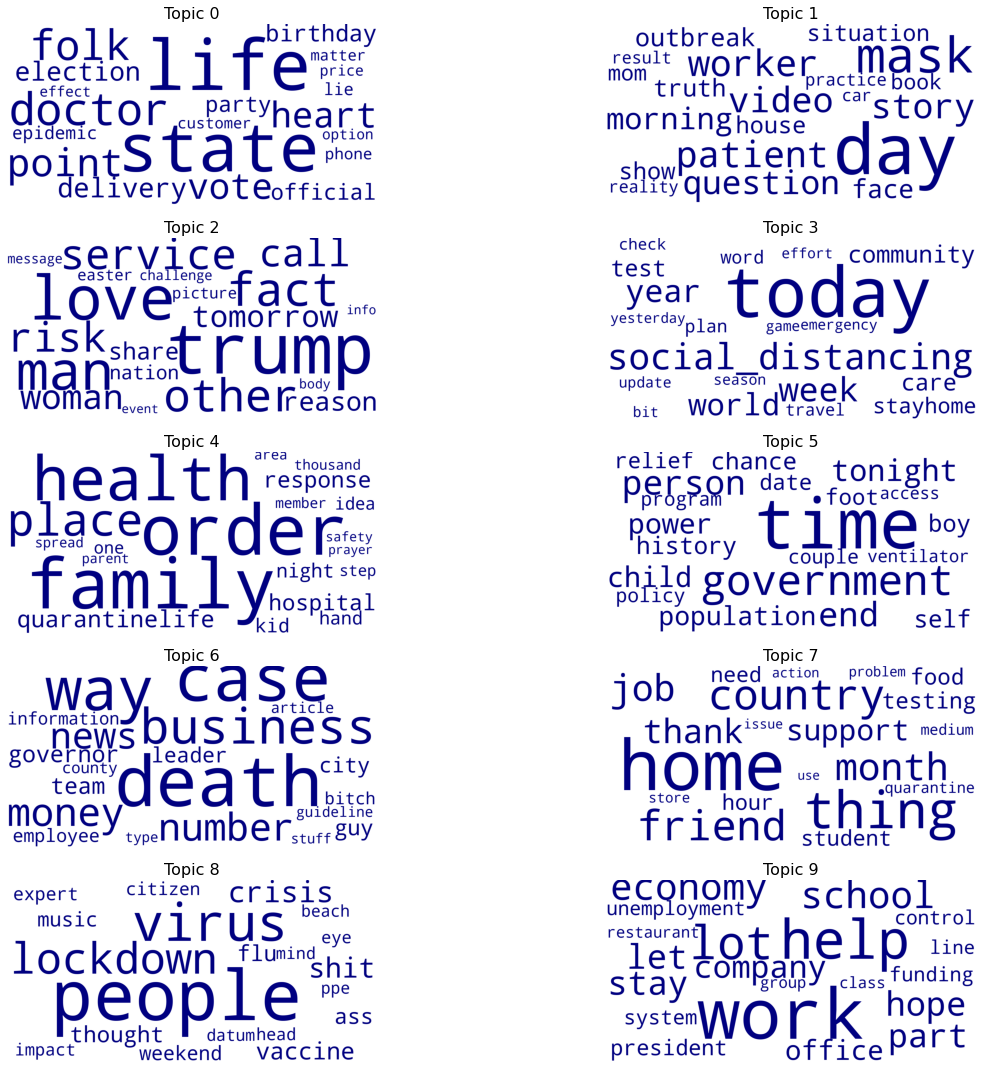

In [61]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=1600,
                  height=800,
                  max_words=20,
                  colormap='tab20',
                  color_func=lambda *args, **kwargs: "navy",
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(10,20,formatted=False)

fig, axes = plt.subplots(5,2,figsize=(20,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words ,max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [57]:
#Save top-topic keywrords result
topics = lda_model.show_topics(formatted=False)
top_words_per_topic = []
for t in range(lda_model.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in lda_model.show_topic(t, topn = 20)])

pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P']).to_csv("top_words_1118_10_100.csv")

In [110]:
# Create counter
import itertools
from collections import Counter
all_words = list(itertools.chain(*data_lemmatized))
counts_all_words = collections.Counter(all_words)
counts_all_words.most_common(50)

[('people', 38805),
 ('mask', 27055),
 ('time', 20081),
 ('virus', 18397),
 ('day', 17159),
 ('home', 15645),
 ('case', 14719),
 ('thing', 11326),
 ('today', 11246),
 ('death', 10912),
 ('year', 10818),
 ('week', 10108),
 ('social_distancing', 9634),
 ('lockdown', 9403),
 ('state', 9243),
 ('work', 9088),
 ('life', 9037),
 ('trump', 7923),
 ('country', 7858),
 ('way', 7830),
 ('family', 7603),
 ('school', 7424),
 ('month', 7183),
 ('health', 6872),
 ('number', 6703),
 ('world', 6538),
 ('test', 6254),
 ('friend', 6148),
 ('job', 5989),
 ('love', 4958),
 ('order', 4905),
 ('man', 4772),
 ('kid', 4747),
 ('care', 4612),
 ('wear', 4603),
 ('help', 4593),
 ('business', 4592),
 ('place', 4554),
 ('hand', 4441),
 ('money', 4420),
 ('shit', 4241),
 ('thank', 4132),
 ('person', 4119),
 ('hospital', 4070),
 ('child', 3977),
 ('lot', 3940),
 ('patient', 3878),
 ('testing', 3771),
 ('government', 3731),
 ('fact', 3562)]

In [112]:
print(counts_no_urls['unemployment'])

1413


In [116]:
print(counts_no_urls['jobloss'])

0


In [113]:
print(counts_no_urls['stress'])

484


In [114]:
print(counts_no_urls['anxiety'])

658


In [117]:
print(counts_no_urls['school'])

7424


In [173]:
print(counts_no_urls['rate'])

1743


In [58]:
topic_words
cloud.generate_from_frequencies(topic_words ,max_font_size=300)


In [59]:
topics = lda_model.show_topics(20,20,formatted=False)
topic_words = dict(topics[8][1])
topic_words

{'people': 0.2068392,
 'virus': 0.10184202,
 'lockdown': 0.0758231,
 'crisis': 0.02790095,
 'shit': 0.024925442,
 'vaccine': 0.017371811,
 'thought': 0.015346111,
 'flu': 0.015059431,
 'ass': 0.0146229835,
 'music': 0.012502219,
 'weekend': 0.011935659,
 'expert': 0.010106671,
 'citizen': 0.009896993,
 'impact': 0.008971443,
 'eye': 0.008925294,
 'head': 0.008571058,
 'mind': 0.008376506,
 'ppe': 0.008151675,
 'datum': 0.008093737,
 'beach': 0.008026333}